In [1]:
import gym

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch

#from ReplayMemory import ReplayMemory, Transition
from DDQN import DDQN
from config import config
from off_policy import off_policy_train

## SETTING

In [2]:
#== CONFIGURATION ==
print('='*4 + ' CONFIGURATION ' + '='*4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
CONFIG = config(RENDER=False, LR_A_END=5e-4, DOUBLE=True, BATCH_SIZE=64, SOFT_UPDATE=True)
for key, value in CONFIG.__dict__.items():
    if key[:1] != '_': 
        print(key, ': ', value)

==== CONFIGURATION ====
cpu
MAX_EPISODES :  200
MAX_EP_STEPS :  200
LR_A :  0.001
LR_A_END :  0.0005
LR_C :  0.001
LR_C_END :  0.0001
EPSILON :  0.9
EPSILON_END :  0.05
MEMORY_CAPACITY :  10000
BATCH_SIZE :  64
GAMMA :  0.9
TAU :  0.01
HARD_UPDATE :  200
SOFT_UPDATE :  True
RENDER :  False
ENV_NAME :  Pendulum-v0
MAX_MODEL :  5
DOUBLE :  True


### ENVIRONMENT

In [3]:
#== Pendulum ==
env = gym.make(CONFIG.ENV_NAME)
env.seed(1)
s_dim = env.observation_space.shape[0]

action_num = 5
action_list = np.linspace(-2, 2, num=action_num, endpoint=True).reshape(-1,1)
r_enhance = lambda r: (r + 8)/8 # reward \in [~-16, 0] -> shift to about [-1, 1]

running_reward = -1000
running_reward_th = -180

### Agent

In [4]:
#== AGENT ==
agent=DDQN(s_dim, action_num, device, CONFIG, action_list)

## TRAINING

In [5]:
from collections import namedtuple

TrainingRecord = namedtuple('TrainingRecord', ['ep', 'avg_reward', 'reward'])
training_records = []

for ep in range(CONFIG.MAX_EPISODES):
    s = env.reset()
    ep_reward = 0.
    for step_num in range(CONFIG.MAX_EP_STEPS):
        print('\r {:d}'.format(step_num), end='')
        if CONFIG.RENDER:
            env.render()
        # action selection
        a, a_idx = agent.select_action(s)

        # interact with env
        s_, r, done, _ = env.step(a)
        ep_reward += r
        if done:
            s_ = None

        # Store the transition in memory
        agent.store_transition(s, a_idx, r_enhance(r), s_)
        s = s_

        # Perform one step of the optimization (on the target network)
        q = agent.update_Q_network()
        if done:
            break
    running_reward = running_reward * 0.9 + ep_reward * 0.1
    training_records.append(TrainingRecord(ep, running_reward, ep_reward))

    if ep % 10 == 0:
        print('\rEp[{:3.0f}]: Running Reward: {:3.2f} \t Real Reward: {:.2f}'.format(ep, running_reward, ep_reward))
    if running_reward > running_reward_th:
        print("\rSolved! Running reward is now {:3.2f}!".format(running_reward))
        env.close()
        break

Ep[  0]: Running Reward: -1051.69 	 Real Reward: -1516.93
Ep[ 10]: Running Reward: -1228.52 	 Real Reward: -1108.99
Ep[ 20]: Running Reward: -756.05 	 Real Reward: -391.07
Ep[ 30]: Running Reward: -405.92 	 Real Reward: -131.47
Ep[ 40]: Running Reward: -279.42 	 Real Reward: -131.74
Ep[ 50]: Running Reward: -220.26 	 Real Reward: -134.47
Ep[ 60]: Running Reward: -215.74 	 Real Reward: -509.86
Ep[ 70]: Running Reward: -242.05 	 Real Reward: -124.33
Ep[ 80]: Running Reward: -250.93 	 Real Reward: -361.52
Ep[ 90]: Running Reward: -233.23 	 Real Reward: -389.78
Solved! Running reward is now -178.47!


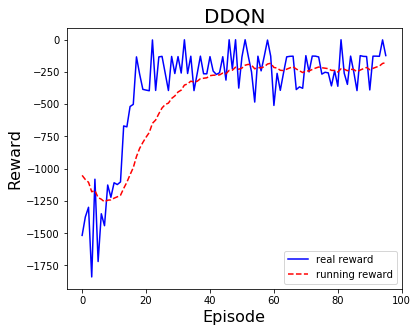

In [6]:
fig = plt.figure(figsize=(6,4.8))
ax = fig.add_subplot(111)
ax.plot([r.ep for r in training_records], [r.reward for r in training_records], 'b-', label='real reward')
ax.plot([r.ep for r in training_records], [r.avg_reward for r in training_records], 'r--', label='running reward')
ax.set_title('DDQN', fontsize=20)
ax.set_xlabel('Episode', fontsize=16)
ax.set_xticks(np.arange(0, 120, 20))
ax.set_ylabel('Reward', fontsize=16)
ax.legend()
plt.savefig("../img/ddqn_pendulum_soft.png")
plt.show()

## Evaluation

In [7]:
'''
s = env.reset()
ep_reward = 0
for i in range(1000):
    env.render()
    # action selection
    a, a_idx = agent.select_action(s)

    # interact with env
    s_, r, _, _ = env.step(a)
    ep_reward += r
    s = s_
print(ep_reward)
env.close()
'''

-133.57159097711485
